# Angle Alignment - Exploring limited slution space (limit to 3 dimensions)

### Content

- [1. Read data for the optimization](#1.-Read-data-for-the-optimization)
- [2. Collect angle alignment data](#2.-Collect-data)
- [3. Visualize 2D solution space and paths of convergence](#3.-Visualize-2D-solution-space-and-paths-of-convergence)
    - [3.1. Successful convergence with LR=0.01](#3.1.-Successful-convergence-with-learning-rate-0.01)
    - [3.2. Successful convergence with LR=0.1](#3.2.-Successful-convergence-with-learning-rate-0.1)
    - [3.3. Unsuccessful convergence with LR=0.01](#3.3.-Unsuccessful-convergence-with-learning-rate-0.01)
    - [3.4. Unsuccessful convergence with LR=0.1](#3.4.-Unsuccessful-convergence-with-learning-rate-0.1)
    - [3.5. Solution space 2D](#3.5.-Solution-space-2D)
- [4. Comparison](#4.-Comparison)
    - [4.1. Comparing successful convergences with different LR](#4.1.-Comparing-successful-convergances-with-different-learning-rates)
    - [4.2. Comparing unsuccessful convergences with different LR](#4.2.-Comparing-unsuccessful-convergances-with-different-learning-rates)
    - [4.3. Solution space 3D](#4.3.--Solution-space-3D)

In [1]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [2]:
#!export CUDA_VISIBLE_DEVICES=""

In [1]:
import numpy as np
import sys
sys.path.append("..")
from oml.angles import quaternion2euler, euler2quaternion
from oml.alignment_limited import training_angle_alignment
import seaborn as sns; sns.set(style="white", color_codes=True)
from tensorflow.keras.optimizers import Adam
import bqplot.scales
from os import path
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12638579630873174359
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14266111750481337263
physical_device_desc: "device: XLA_CPU device"
]


# 1. Read data for the optimization

In [4]:
# read predicted quaternions and convert to euler angles
quaternion_predicted = np.load("../data/predicted_quaternions2.npy")
angles_predicted = quaternion2euler(quaternion_predicted).numpy()

In [5]:
# read true angles and convert to quaternions
angles_true = np.load("../data/angles_true.npy")
quaternion_true = euler2quaternion(angles_true)

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

# 2. Collect data

Vary learning rate and starting points.

In [8]:
# unscuccessful convergence start point
rot = [2. , .5, 3., 3.06273475, 2.56179193, 3.82298411]
# successful convergence starting point
rot = [4. , 2., 3., 3.06273475, 2.56179193, 3.82298411]

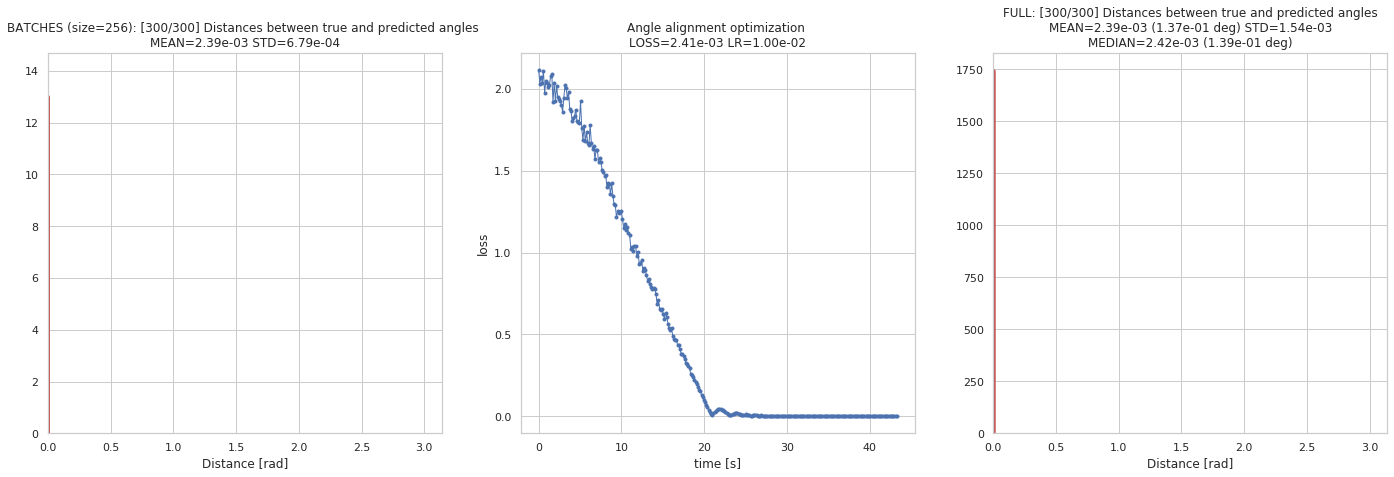

step 30/300 (4s): loss = 1.98e+00
step 60/300 (9s): loss = 1.65e+00
step 90/300 (13s): loss = 1.13e+00
step 120/300 (17s): loss = 6.34e-01
step 150/300 (22s): loss = 1.71e-01
step 180/300 (26s): loss = 1.83e-02
step 210/300 (30s): loss = 3.64e-03
step 240/300 (35s): loss = 2.51e-03
step 270/300 (39s): loss = 2.52e-03
step 300/300 (44s): loss = 2.46e-03

---


In [9]:
m, rotation1, rotation2, loss, collect_data, Rs  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted,
                                                 rot_init=rot)

In [88]:
np.savez('../data/lr0.01_2,0.5,3.npz', Rs=Rs, loss=loss)

In [86]:
np.savez('../data/lr0.1_2,0.5,3.npz', Rs=Rs, loss=loss)

In [84]:
np.savez('../data/lr1.0_2,0.5,3.npz', Rs=Rs, loss=loss)

In [97]:
np.savez('../data/lr3.0_2,0.5,3.npz', Rs=Rs, loss=loss)

In [105]:
# collect data from solution space  (takes some time)
if not path.exists("losses3d_full.npy"):
    x_size, y_size, z_size = 100, 100, 100
    x, y, z = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, x_size), np.linspace(-2*np.pi, 2*np.pi, y_size), np.linspace(-2*np.pi, 2*np.pi, z_size))

    losses = []
    rotations = []

    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    for i, j, k in zip(x, y, z):
        # iterate first 3 dimensions, last 3 are fixed to the estimated ones

        losses.append(loss_alignment([1., 1., 1., 1.], [[i, j, k]], [rot[3:]], quaternion_predicted, quaternion_true))
        rotations.append([i, j, k])

    losses = np.array(losses)
    rotations = np.array(rotations)

    np.save("../data/losses3d_full.npy", losses)
    np.save("../data/rotations3d_full.npy", rotations)

## 3. Visualize 2D solution space and paths of convergence

In [54]:
def run_alignment(num_runs, steps, batch_size, lr, rot):
    successful = 0
    for run  in range(1, num_runs+1):
        m, rotation1, rotation2, losses, collect_data, Rs  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                     steps=steps, 
                                                     batch_size=batch_size, 
                                                     learning_rate=lr, 
                                                     angles_true=angles_true, 
                                                     angles_predicted=angles_predicted,
                                                     rot_init=rot)
        file_name = f"rot_{','.join(map(str, rot))}_steps_{str(steps)}_batch_{str(batch_size)}_lr_{str(lr)}_run_{str(run)}"
        #np.savez(file_name, Rs=Rs, losses=losses)
        print(f"Finished: {file_name}")
        # ADD INITIAL LOSS AND ROTATION
        Rs = np.vstack((rot, Rs))
        plt.plot(Rs[:,0], Rs[:,1], lw=2, ls='--', color="black", label=f"lr={lr}")
        print(f"Loss: {losses[-1]}")
        if losses[-1] < 0.1:
            successful += 1
        plt.plot(Rs[-1,0], Rs[-1,1], markersize=10, mew=5, marker="x", color="green", label="finish point")
        
    print(f"Successful convergances: {successful}")      

### 3.1. Successful convergence with learning rate 0.01

Finished: rot_4.0,2.0,3.0,3.06273475,2.56179193,3.82298411_steps_300_batch_256_lr_0.01_run_1
Loss: 0.0027908112227936154
Successful convergances: 1


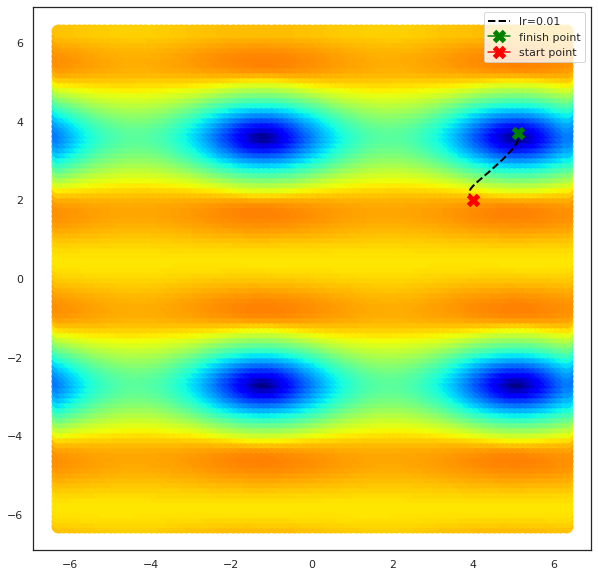

In [58]:
# starting point rotation
rot = [4. , 2., 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 22 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

# PLOT
cmap = plt.get_cmap('jet')
color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)

run_alignment(num_runs=1, steps=300, batch_size=256, lr=.01, rot=rot)

plt.plot(rot[0], rot[1], markersize=10, mew=5, marker="x", color="red", label="start point")

plt.legend()
plt.show()

### 3.2. Successful convergence with learning rate 0.1

Finished: rot_4.0,2.0,3.0,3.06273475,2.56179193,3.82298411_steps_300_batch_256_lr_0.1_run_1
Loss: 0.009911236720659305
Successful convergances: 1


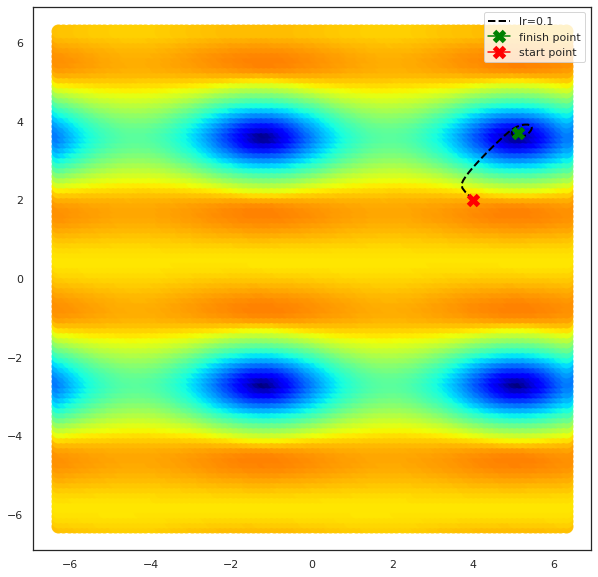

In [61]:
# starting point rotation
rot = [4. , 2., 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 22 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

# PLOT
cmap = plt.get_cmap('jet')
color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)

run_alignment(num_runs=1, steps=300, batch_size=256, lr=.1, rot=rot)

plt.plot(rot[0], rot[1], markersize=10, mew=5, marker="x", color="red", label="start point")

plt.legend()
plt.show()

### 3.3. Unsuccessful convergence with learning rate 0.01

Finished: rot_2.0,0.5,3.0,3.06273475,2.56179193,3.82298411_steps_300_batch_256_lr_0.01_run_1
Loss: 1.8459349659396955
Successful convergances: 0


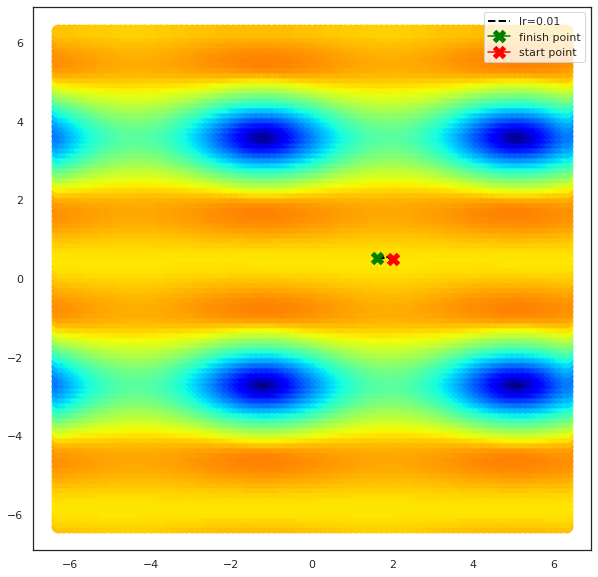

In [60]:
# starting point rotation
rot = [2. , .5, 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 22 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

# PLOT
cmap = plt.get_cmap('jet')
color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)

run_alignment(num_runs=1, steps=300, batch_size=256, lr=.01, rot=rot)

plt.plot(rot[0], rot[1], markersize=10, mew=5, marker="x", color="red", label="start point")

plt.legend()
plt.show()

### 3.4. Unsuccessful convergence with learning rate 0.1

Finished: rot_2.0,0.5,3.0,3.06273475,2.56179193,3.82298411_steps_300_batch_256_lr_0.1_run_1
Loss: 1.8570445916803953
Successful convergances: 0


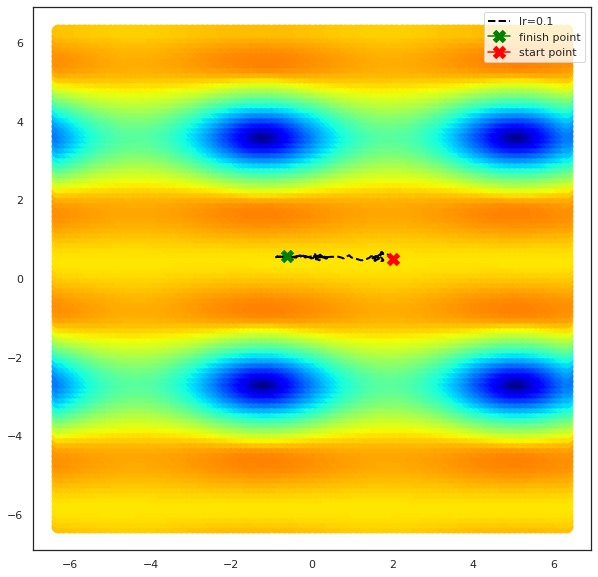

In [62]:
# starting point rotation
rot = [2. , .5, 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 22 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()

# PLOT
cmap = plt.get_cmap('jet')
color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)

run_alignment(num_runs=1, steps=300, batch_size=256, lr=.1, rot=rot)

plt.plot(rot[0], rot[1], markersize=10, mew=5, marker="x", color="red", label="start point")

plt.legend()
plt.show()

### 3.5. Solution space 2D

![](../images/solution_space_2D.gif)

## 4. Comparison

### 4.1. Comparing successful convergances with different learning rates

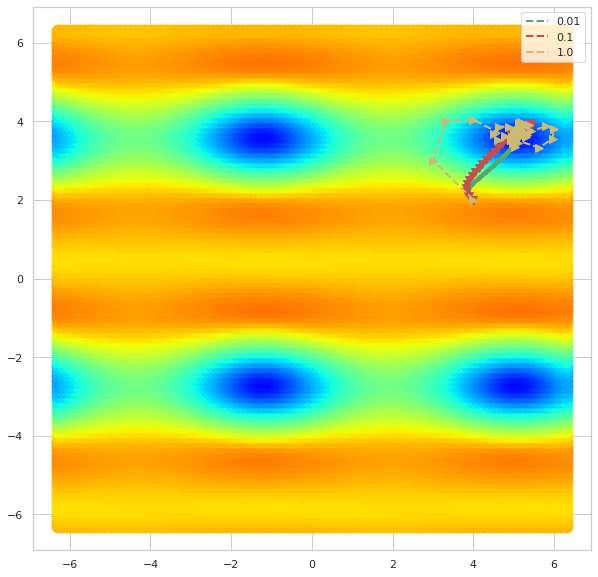

In [108]:
rot = [4. , 2., 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# LR=0.01
lr1 = np.load("../data/lr0.01.npz")
lr1_Rs, lr1_loss = lr1['Rs'], lr1['loss']

# LR=0.1
lr2 = np.load("../data/lr0.1.npz")
lr2_Rs, lr2_loss = lr2['Rs'], lr2['loss']

# LR=1.
lr3 = np.load("../data/lr1.0.npz")
# shape: 300, 6
lr3_Rs, lr3_loss = lr3['Rs'], lr3['loss']


# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))

# ADD INITIAL LOSS AND ROTATION
loss_first = loss_alignment([1., 1., 1., 1.], [rot[:3]], [rot[3:]], quaternion_predicted, quaternion_true).numpy()

lr1_loss = np.hstack((loss_first, lr1_loss))
lr1_Rs = np.vstack((rot, lr1_Rs))
lr2_loss = np.hstack((loss_first, lr2_loss))
lr2_Rs = np.vstack((rot, lr2_Rs))
lr3_loss = np.hstack((loss_first, lr3_loss[:50]))
lr3_Rs = np.vstack((rot, lr3_Rs[:50]))

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 20 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()


# PLOT
cmap = plt.get_cmap('jet')
color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)
    
############
loss_opt = (lr1_loss - min(lr1_loss))/(max(lr1_loss) - min(lr1_loss))
color_lr1 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr1[i, :] = list(cmap(c))

plt.plot(lr1_Rs[:,0], lr1_Rs[:,1], markersize=3, lw=2, color='g', ls='--', label="0.01")
for i in range(len(loss_opt)):
    plt.plot(lr1_Rs[:,0][i], lr1_Rs[:,1][i], markersize=3, marker='o', color="g")#color_lr1[i])
    
############
loss_opt = (lr2_loss - min(lr2_loss))/(max(lr2_loss) - min(lr2_loss))
color_lr2 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr2[i, :] = list(cmap(c))
plt.plot(lr2_Rs[:,0], lr2_Rs[:,1], markersize=3, lw=2, color='r', ls='--', label="0.1")
for i in range(len(loss_opt)):
    plt.plot(lr2_Rs[:,0][i], lr2_Rs[:,1][i], markersize=8, marker='v', color="r")#color_lr2[i])
    
############
loss_opt = (lr3_loss - min(lr3_loss))/(max(lr3_loss) - min(lr3_loss))
color_lr3 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr3[i, :] = list(cmap(c))
plt.plot(lr3_Rs[:,0], lr3_Rs[:,1], markersize=3, lw=2, color='y', ls='--', label="1.0")
for i in range(len(loss_opt)):
    plt.plot(lr3_Rs[:,0][i], lr3_Rs[:,1][i], markersize=8, marker='>', color="y")#color_lr3[i])
    
plt.legend()

### 4.2. Comparing unsuccessful convergances with different learning rates

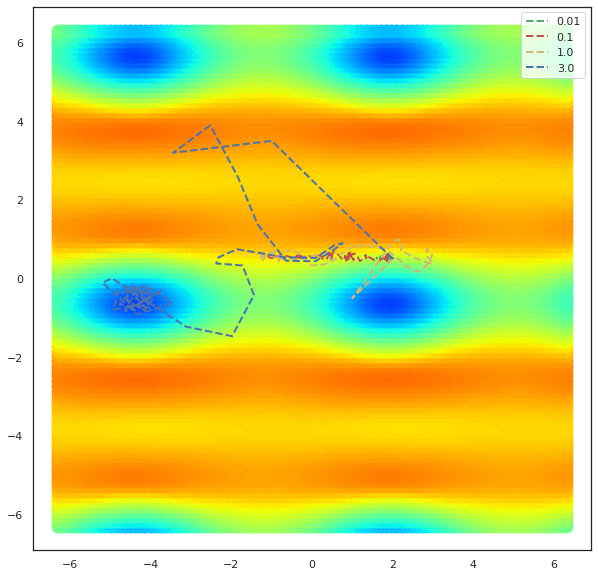

In [12]:
rot = [2. , .5, 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# LR=0.01
lr1 = np.load("../data/lr0.01_2,0.5,3.npz")
lr1_Rs, lr1_loss = lr1['Rs'], lr1['loss']

# LR=0.1
lr2 = np.load("../data/lr0.1_2,0.5,3.npz")
lr2_Rs, lr2_loss = lr2['Rs'], lr2['loss']

# LR=1.0
lr3 = np.load("../data/lr1.0_2,0.5,3.npz")
# shape: 300, 6
lr3_Rs, lr3_loss = lr3['Rs'], lr3['loss']

# LR=3.0
lr4 = np.load("../data/lr3.0_2,0.5,3.npz")
# shape: 300, 6
lr4_Rs, lr4_loss = lr4['Rs'], lr4['loss']

# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))

# ADD INITIAL LOSS AND ROTATION
loss_first = loss_alignment([1., 1., 1., 1.], [rot[:3]], [rot[3:]], quaternion_predicted, quaternion_true).numpy()

lr1_loss = np.hstack((loss_first, lr1_loss))
lr1_Rs = np.vstack((rot, lr1_Rs))
lr2_loss = np.hstack((loss_first, lr2_loss))
lr2_Rs = np.vstack((rot, lr2_Rs))
lr3_loss = np.hstack((loss_first, lr3_loss[:50]))
lr3_Rs = np.vstack((rot, lr3_Rs[:50]))
lr4_loss = np.hstack((loss_first, lr4_loss[:50]))
lr4_Rs = np.vstack((rot, lr4_Rs[:50]))

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
i = 99 # layer
x = x.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
y = y.reshape((x_size, y_size, z_size ))[:, :, i].flatten()
losses_part = losses.reshape((x_size, y_size, z_size ))[:, :, i].flatten()


# PLOT
cmap = plt.get_cmap('jet')

color_grid = np.empty((len(losses_part), 4))
for i, c in enumerate(losses_part):
    color_grid[i, :] = list(cmap(c))
    
fig = plt.figure(figsize=(10, 10))
for i in range(len(losses_part)):
    plt.plot(x[i], y[i], markersize=13, marker='o', color=color_grid[i], lw=0)
    
############
loss_opt = (lr1_loss - min(lr1_loss))/(max(lr1_loss) - min(lr1_loss))
color_lr1 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr1[i, :] = list(cmap(c))

plt.plot(lr1_Rs[:,0], lr1_Rs[:,1], markersize=3, lw=2, color='g', ls='--', label="0.01")
# for i in range(len(loss_opt)):
#     plt.plot(lr1_Rs[:,0][i], lr1_Rs[:,1][i], markersize=3, marker='o', color="g")#color_lr1[i])
    
############
loss_opt = (lr2_loss - min(lr2_loss))/(max(lr2_loss) - min(lr2_loss))
color_lr2 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr2[i, :] = list(cmap(c))
plt.plot(lr2_Rs[:,0], lr2_Rs[:,1], markersize=3, lw=2, color='r', ls='--', label="0.1")
# for i in range(len(loss_opt)):
#     plt.plot(lr2_Rs[:,0][i], lr2_Rs[:,1][i], markersize=8, marker='v', color="r")#color_lr2[i])
    
############
loss_opt = (lr3_loss - min(lr3_loss))/(max(lr3_loss) - min(lr3_loss))
color_lr3 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr3[i, :] = list(cmap(c))
plt.plot(lr3_Rs[:,0], lr3_Rs[:,1], markersize=3, lw=2, color='y', ls='--', label="1.0")
# for i in range(len(loss_opt)):
#     plt.plot(lr3_Rs[:,0][i], lr3_Rs[:,1][i], markersize=8, marker='>', color="y")#color_lr3[i])
    
############
loss_opt = (lr4_loss - min(lr4_loss))/(max(lr4_loss) - min(lr4_loss))
color_lr4 = np.empty((len(loss_opt), 4))
for i, c in enumerate(loss_opt):
    color_lr4[i, :] = list(cmap(c))
plt.plot(lr4_Rs[:,0], lr4_Rs[:,1], markersize=3, lw=2, color='b', ls='--', label="3.0")
# for i in range(len(loss_opt)):
#     plt.plot(lr4_Rs[:,0][i], lr4_Rs[:,1][i], markersize=8, marker='>', color="b")#color_lr3[i])
    
plt.legend()

### 4.3.  Solution space 3D

In [13]:
rot = [2. , .5, 3., 3.06273475, 2.56179193, 3.82298411]

# READ DATA
roi = np.arange(100*100*100)
losses = np.take(np.load("../data/losses3d_full.npy"), roi, axis=0)
# shape: 125000, 3
rotations = np.take(np.load("../data/rotations3d_full.npy"), roi, axis=0)

# shape: 125000
losses = (losses-min(losses))/(max(losses)-min(losses))

# Read solution space
x, y, z = rotations[:,0], rotations[:,1], rotations[:,2]
x_size, y_size, z_size = 100, 100, 100
#i = 99 # layer
x = x.reshape((x_size, y_size, z_size )).flatten()
y = y.reshape((x_size, y_size, z_size )).flatten()
losses_part = losses.reshape((x_size, y_size, z_size )).flatten()

# QUICK TEST: STARTS FROM RED, GO TO BLUE
import bqplot.scales

ipv.figure()
colss = np.empty((len(losses), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(losses):
    colss[i, :] = list(cmap(c))

#colss[:,0] = 1.0
colss[:,3] = .1
s = ipv.scatter(x, y, z, color=colss, marker='sphere', size=2)#, size=2, opacity=0.01)
s.material.transparent = True

loss_opt = (lr1_loss - min(lr1_loss))/(max(lr1_loss) - min(lr1_loss))
cols = np.empty((len(loss_opt), 4))
cmap = plt.get_cmap('jet')
for i, c in enumerate(loss_opt):
    cols[i, :] = list(cmap(c))
ipv.scatter(lr1_Rs[:,0], lr1_Rs[:,1], lr1_Rs[:,2], color=cols)

ipv.show()   

![](../images/solution_space3d.gif)

![](../images/soution_space3d.gif)